In [1]:
import glob
import pandas as pd
import numpy as np
import imageio
from skimage.transform import resize
from scipy import misc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau 
from keras.utils import np_utils, normalize

Using TensorFlow backend.


In [4]:
# Use this to supress warnings from scipy in the meantime
import warnings
warnings.filterwarnings("ignore")

In [5]:
PATH_DATA = './Data/'
PATH_IMAGES = glob.glob('./Images/*.jpg')

In [6]:
df_meta = pd.read_csv(PATH_DATA + 'HAM10000_metadata.csv')

## I. EDA

In [7]:
df_meta.shape

(10015, 7)

In [8]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
lesion_id       10015 non-null object
image_id        10015 non-null object
dx              10015 non-null object
dx_type         10015 non-null object
age             9958 non-null float64
sex             10015 non-null object
localization    10015 non-null object
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [9]:
df_meta.isna().isna().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [10]:
df_meta.describe(include='all')

,lesion_id,image_id,dx,dx_type,age,sex,localization
count,10015,10015,10015,10015,9958.000000,10015,10015
unique,7470,10015,7,4,NaN,3,15
top,HAM_0003789,ISIC_0034233,nv,histo,NaN,male,back
freq,6,1,6705,5340,NaN,5406,2192
mean,NaN,NaN,NaN,NaN,51.863828,NaN,NaN
std,NaN,NaN,NaN,NaN,16.968614,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,40.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,50.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,65.000000,NaN,NaN


In [11]:
df_meta.sample(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
3261,HAM_0005046,ISIC_0029561,nv,follow_up,50.0,female,back
2598,HAM_0002526,ISIC_0032799,bcc,histo,75.0,male,trunk
5891,HAM_0004460,ISIC_0028784,nv,follow_up,65.0,female,lower extremity
4670,HAM_0000033,ISIC_0031861,nv,follow_up,40.0,female,lower extremity
9711,HAM_0002745,ISIC_0024562,akiec,histo,75.0,male,chest
3807,HAM_0006950,ISIC_0027215,nv,follow_up,60.0,male,lower extremity
2239,HAM_0007522,ISIC_0027904,mel,histo,55.0,female,upper extremity
810,HAM_0005896,ISIC_0024814,bkl,confocal,50.0,female,face
5170,HAM_0006959,ISIC_0032286,nv,follow_up,35.0,male,back
7648,HAM_0002139,ISIC_0033788,nv,histo,10.0,female,upper extremity


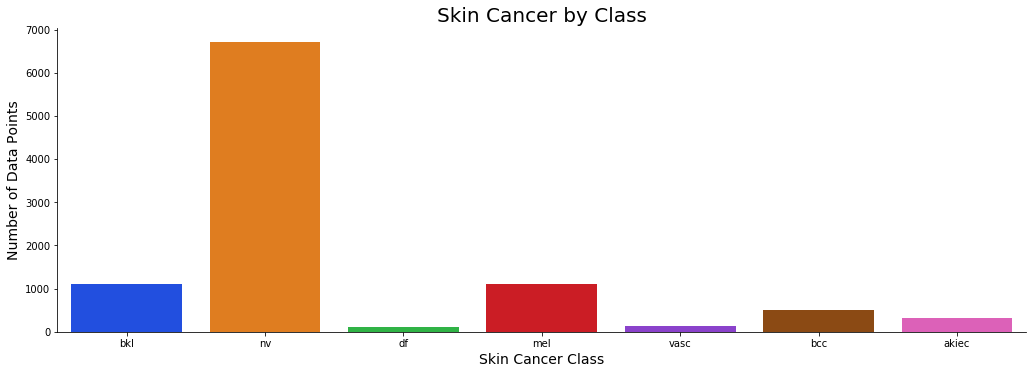

In [12]:
# For this project we need to predict the cancer type, let's check the distribution of the values
g = sns.catplot(x="dx", kind="count", palette='bright', data=df_meta)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Skin Cancer by Class', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)

### There is a class imbalance here with 'nv' comprising more than 65% of the overall data, this will have an impact later during the classification
***

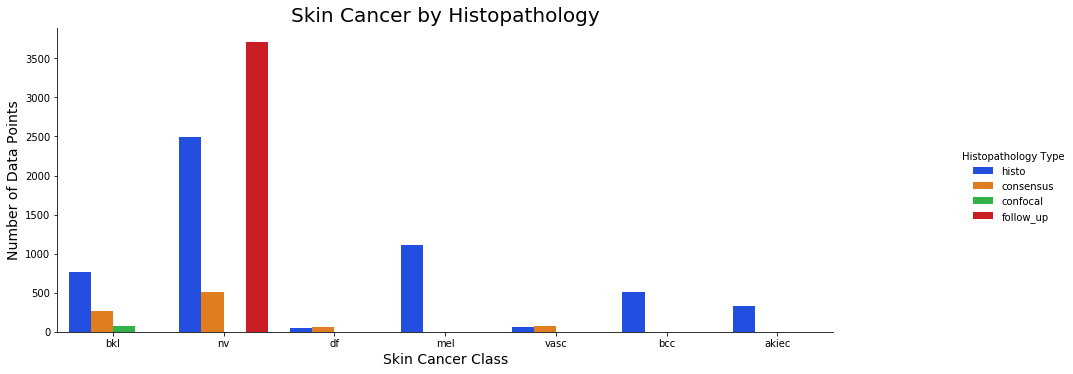

In [13]:
# Skin Cancer is confirmed via Hispathology, let's check the breakdown for each type
g = sns.catplot(x="dx", kind="count", hue="dx_type", palette='bright', data=df_meta)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Skin Cancer by Histopathology', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)
g._legend.set_title('Histopathology Type')

### It seems that all of 'nv' are confirmed through follow-up, this behavior is not seen for other cancer class
***

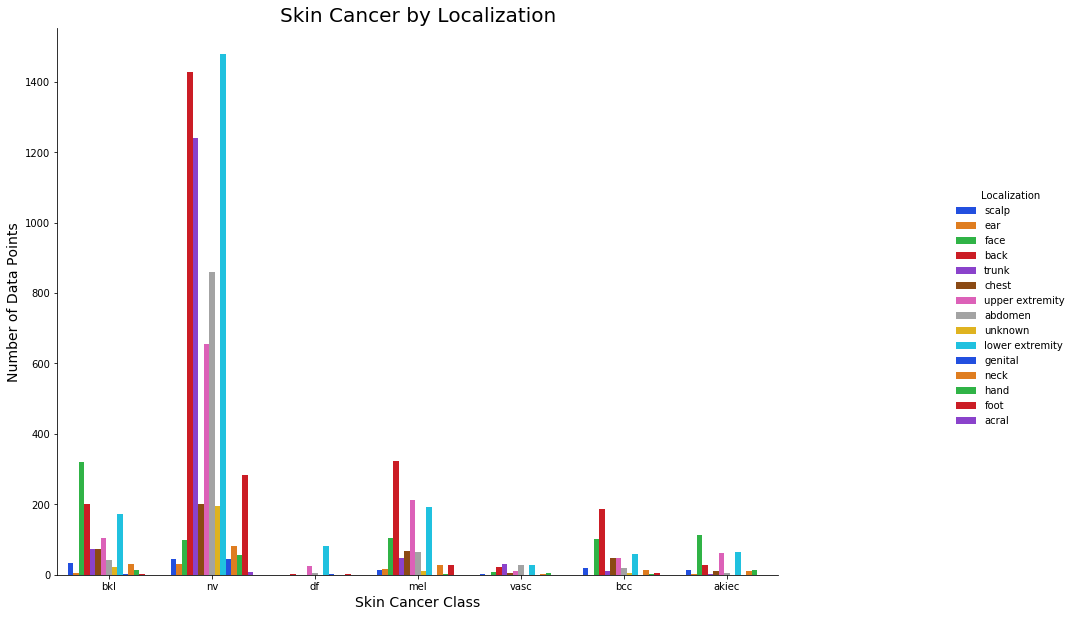

In [14]:
# Skin Cancer occurence body localization
g = sns.catplot(x="dx", kind="count", hue="localization", palette='bright', data=df_meta)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer by Localization', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)
g._legend.set_title('Localization')

### Skin cancer seems to have more occurence in the back and lower extrimity of people, may indicate over-exposure to the sun in water activities
***

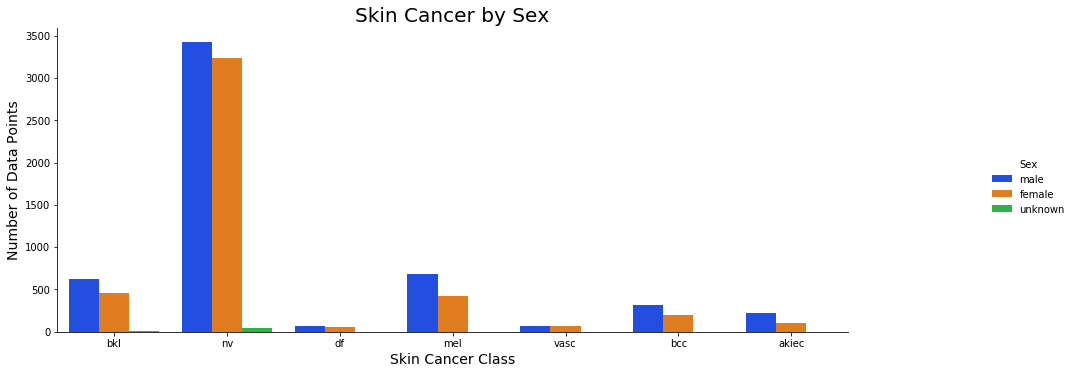

In [15]:
# Skin Cancer occurence by Gender
g = sns.catplot(x="dx", kind="count", hue="sex", palette='bright', data=df_meta)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Skin Cancer by Sex', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)
g._legend.set_title('Sex')

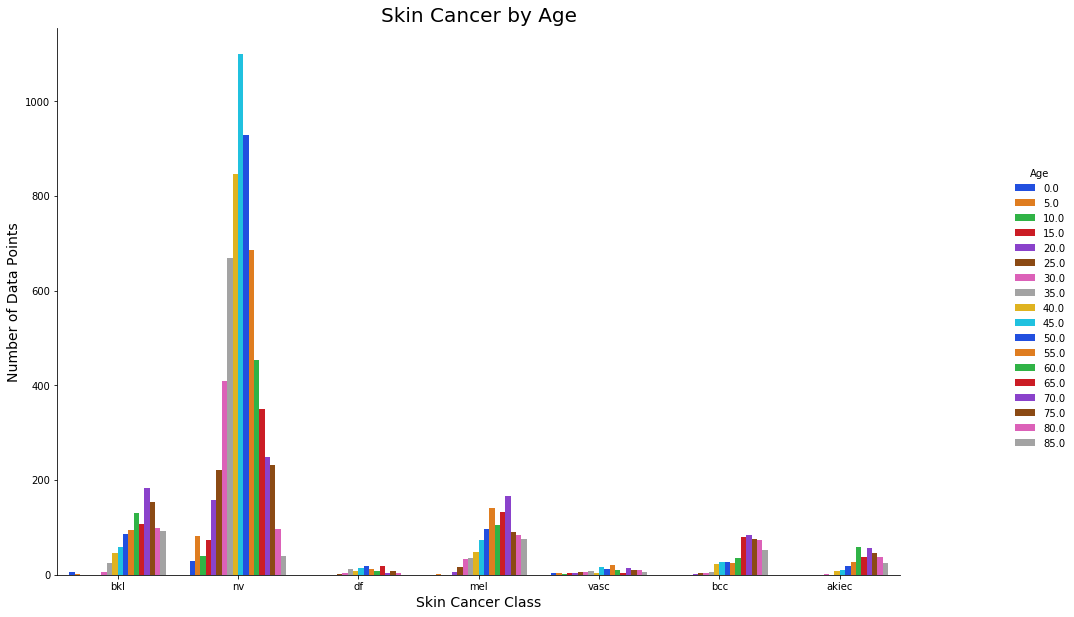

In [16]:
# Skin Cancer occurence by Age
g = sns.catplot(x="dx", kind="count", hue="age", palette='bright', data=df_meta)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer by Age', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)
g._legend.set_title('Age')

### While 'nv' is the most common of cancer class in the dataset, it seems to occur more for middle age while for other cancer class, it seems to occur more at a later age
***

## II. Load the Images and prepare for Train/Test Split

In [17]:
# Prepare Train and Test Data
df_meta = df_meta.set_index('image_id')
y = pd.get_dummies(df_meta[['dx']])
y_train, y_test = train_test_split(y, test_size=0.2, random_state=42)

In [18]:
# Original Size: 600*450
# Metho: Load all Images and Resize to 30%, with normalization

TARGET_SIZE = (180, 135)

x_train, x_test = [], []
for image_id in y_train.index.values:
    # Uses too much memory, will revert first to scipy
    # image = imageio.imread('./Images/{}.jpg'.format(image_id))
    # image = resize(image, output_shape=(360, 270), anti_aliasing=False, mode='constant')
    
    image = misc.imread('./Images/{}.jpg'.format(image_id))
    image = misc.imresize(image, size=TARGET_SIZE, interp='nearest')
    image = normalize(image)
    x_train.append(image)
    print('Completed processing {}.jpg'.format(image_id))

x_train = np.asarray(x_train)

for image_id in y_test.index.values:
    # Uses too much memory, will revert first to scipy
    # image = imageio.imread('./Images/{}.jpg'.format(image_id))
    # image = resize(image, output_shape=(360, 270), anti_aliasing=False, mode='constant')
    
    image = misc.imread('./Images/{}.jpg'.format(image_id))
    image = misc.imresize(image, size=TARGET_SIZE, interp='nearest')
    image = normalize(image)
    x_test.append(image)
    print('Completed processing {}.jpg'.format(image_id))

x_test = np.asarray(x_test)

Completed processing ISIC_0027223.jpg
Completed processing ISIC_0032914.jpg
Completed processing ISIC_0033614.jpg
Completed processing ISIC_0026219.jpg
Completed processing ISIC_0033900.jpg
Completed processing ISIC_0031846.jpg
Completed processing ISIC_0032163.jpg
Completed processing ISIC_0033945.jpg
Completed processing ISIC_0032329.jpg
Completed processing ISIC_0025860.jpg
Completed processing ISIC_0027338.jpg
Completed processing ISIC_0032605.jpg
Completed processing ISIC_0027008.jpg
Completed processing ISIC_0030154.jpg
Completed processing ISIC_0024585.jpg
Completed processing ISIC_0034064.jpg
Completed processing ISIC_0033560.jpg
Completed processing ISIC_0024859.jpg
Completed processing ISIC_0031458.jpg
Completed processing ISIC_0029097.jpg
Completed processing ISIC_0025782.jpg
Completed processing ISIC_0030176.jpg
Completed processing ISIC_0031785.jpg
Completed processing ISIC_0026954.jpg
Completed processing ISIC_0032986.jpg
Completed processing ISIC_0033601.jpg
Completed pr

Completed processing ISIC_0032565.jpg
Completed processing ISIC_0025898.jpg
Completed processing ISIC_0028466.jpg
Completed processing ISIC_0026361.jpg
Completed processing ISIC_0034222.jpg
Completed processing ISIC_0031884.jpg
Completed processing ISIC_0034149.jpg
Completed processing ISIC_0028416.jpg
Completed processing ISIC_0025513.jpg
Completed processing ISIC_0031995.jpg
Completed processing ISIC_0026764.jpg
Completed processing ISIC_0030521.jpg
Completed processing ISIC_0025642.jpg
Completed processing ISIC_0034203.jpg
Completed processing ISIC_0028165.jpg
Completed processing ISIC_0025702.jpg
Completed processing ISIC_0027486.jpg
Completed processing ISIC_0027823.jpg
Completed processing ISIC_0029668.jpg
Completed processing ISIC_0027784.jpg
Completed processing ISIC_0027368.jpg
Completed processing ISIC_0033376.jpg
Completed processing ISIC_0026883.jpg
Completed processing ISIC_0029094.jpg
Completed processing ISIC_0026641.jpg
Completed processing ISIC_0026453.jpg
Completed pr

Completed processing ISIC_0028262.jpg
Completed processing ISIC_0032231.jpg
Completed processing ISIC_0033399.jpg
Completed processing ISIC_0030939.jpg
Completed processing ISIC_0031332.jpg
Completed processing ISIC_0026166.jpg
Completed processing ISIC_0025065.jpg
Completed processing ISIC_0028241.jpg
Completed processing ISIC_0026971.jpg
Completed processing ISIC_0024946.jpg
Completed processing ISIC_0032111.jpg
Completed processing ISIC_0033561.jpg
Completed processing ISIC_0030195.jpg
Completed processing ISIC_0025910.jpg
Completed processing ISIC_0032477.jpg
Completed processing ISIC_0031871.jpg
Completed processing ISIC_0031495.jpg
Completed processing ISIC_0027430.jpg
Completed processing ISIC_0026673.jpg
Completed processing ISIC_0025738.jpg
Completed processing ISIC_0030465.jpg
Completed processing ISIC_0034177.jpg
Completed processing ISIC_0027259.jpg
Completed processing ISIC_0031110.jpg
Completed processing ISIC_0027061.jpg
Completed processing ISIC_0026569.jpg
Completed pr

Completed processing ISIC_0029352.jpg
Completed processing ISIC_0031555.jpg
Completed processing ISIC_0028938.jpg
Completed processing ISIC_0025587.jpg
Completed processing ISIC_0025890.jpg
Completed processing ISIC_0030357.jpg
Completed processing ISIC_0027676.jpg
Completed processing ISIC_0026035.jpg
Completed processing ISIC_0031574.jpg
Completed processing ISIC_0027881.jpg
Completed processing ISIC_0030372.jpg
Completed processing ISIC_0030800.jpg
Completed processing ISIC_0025847.jpg
Completed processing ISIC_0032113.jpg
Completed processing ISIC_0027830.jpg
Completed processing ISIC_0030005.jpg
Completed processing ISIC_0027016.jpg
Completed processing ISIC_0031083.jpg
Completed processing ISIC_0028437.jpg
Completed processing ISIC_0032426.jpg
Completed processing ISIC_0029756.jpg
Completed processing ISIC_0027099.jpg
Completed processing ISIC_0030386.jpg
Completed processing ISIC_0024361.jpg
Completed processing ISIC_0031670.jpg
Completed processing ISIC_0027587.jpg
Completed pr

Completed processing ISIC_0027064.jpg
Completed processing ISIC_0029130.jpg
Completed processing ISIC_0024475.jpg
Completed processing ISIC_0032669.jpg
Completed processing ISIC_0024611.jpg
Completed processing ISIC_0025790.jpg
Completed processing ISIC_0025802.jpg
Completed processing ISIC_0024462.jpg
Completed processing ISIC_0029263.jpg
Completed processing ISIC_0026555.jpg
Completed processing ISIC_0027068.jpg
Completed processing ISIC_0033966.jpg
Completed processing ISIC_0030794.jpg
Completed processing ISIC_0026725.jpg
Completed processing ISIC_0028017.jpg
Completed processing ISIC_0032262.jpg
Completed processing ISIC_0025942.jpg
Completed processing ISIC_0029503.jpg
Completed processing ISIC_0027748.jpg
Completed processing ISIC_0030466.jpg
Completed processing ISIC_0024987.jpg
Completed processing ISIC_0030713.jpg
Completed processing ISIC_0033012.jpg
Completed processing ISIC_0027401.jpg
Completed processing ISIC_0027054.jpg
Completed processing ISIC_0034039.jpg
Completed pr

Completed processing ISIC_0028370.jpg
Completed processing ISIC_0031915.jpg
Completed processing ISIC_0032723.jpg
Completed processing ISIC_0027324.jpg
Completed processing ISIC_0026424.jpg
Completed processing ISIC_0029758.jpg
Completed processing ISIC_0030421.jpg
Completed processing ISIC_0025845.jpg
Completed processing ISIC_0026859.jpg
Completed processing ISIC_0032972.jpg
Completed processing ISIC_0032570.jpg
Completed processing ISIC_0026603.jpg
Completed processing ISIC_0030751.jpg
Completed processing ISIC_0029408.jpg
Completed processing ISIC_0026928.jpg
Completed processing ISIC_0027391.jpg
Completed processing ISIC_0025223.jpg
Completed processing ISIC_0025267.jpg
Completed processing ISIC_0032823.jpg
Completed processing ISIC_0031105.jpg
Completed processing ISIC_0026969.jpg
Completed processing ISIC_0030151.jpg
Completed processing ISIC_0032564.jpg
Completed processing ISIC_0033621.jpg
Completed processing ISIC_0030680.jpg
Completed processing ISIC_0033720.jpg
Completed pr

Completed processing ISIC_0032961.jpg
Completed processing ISIC_0030659.jpg
Completed processing ISIC_0034232.jpg
Completed processing ISIC_0031712.jpg
Completed processing ISIC_0032253.jpg
Completed processing ISIC_0026669.jpg
Completed processing ISIC_0026862.jpg
Completed processing ISIC_0032878.jpg
Completed processing ISIC_0031335.jpg
Completed processing ISIC_0034119.jpg
Completed processing ISIC_0028798.jpg
Completed processing ISIC_0025078.jpg
Completed processing ISIC_0025829.jpg
Completed processing ISIC_0026016.jpg
Completed processing ISIC_0025735.jpg
Completed processing ISIC_0032066.jpg
Completed processing ISIC_0028538.jpg
Completed processing ISIC_0032183.jpg
Completed processing ISIC_0028791.jpg
Completed processing ISIC_0026733.jpg
Completed processing ISIC_0028667.jpg
Completed processing ISIC_0025303.jpg
Completed processing ISIC_0026037.jpg
Completed processing ISIC_0025640.jpg
Completed processing ISIC_0027059.jpg
Completed processing ISIC_0031580.jpg
Completed pr

Completed processing ISIC_0026985.jpg
Completed processing ISIC_0025741.jpg
Completed processing ISIC_0025184.jpg
Completed processing ISIC_0024430.jpg
Completed processing ISIC_0025024.jpg
Completed processing ISIC_0025946.jpg
Completed processing ISIC_0026739.jpg
Completed processing ISIC_0029452.jpg
Completed processing ISIC_0025574.jpg
Completed processing ISIC_0030261.jpg
Completed processing ISIC_0028918.jpg
Completed processing ISIC_0033591.jpg
Completed processing ISIC_0025858.jpg
Completed processing ISIC_0027906.jpg
Completed processing ISIC_0025444.jpg
Completed processing ISIC_0028887.jpg
Completed processing ISIC_0028657.jpg
Completed processing ISIC_0033137.jpg
Completed processing ISIC_0024682.jpg
Completed processing ISIC_0030113.jpg
Completed processing ISIC_0029378.jpg
Completed processing ISIC_0032414.jpg
Completed processing ISIC_0031079.jpg
Completed processing ISIC_0030123.jpg
Completed processing ISIC_0027691.jpg
Completed processing ISIC_0032636.jpg
Completed pr

Completed processing ISIC_0032896.jpg
Completed processing ISIC_0029693.jpg
Completed processing ISIC_0027949.jpg
Completed processing ISIC_0026717.jpg
Completed processing ISIC_0033428.jpg
Completed processing ISIC_0026780.jpg
Completed processing ISIC_0033377.jpg
Completed processing ISIC_0033143.jpg
Completed processing ISIC_0031936.jpg
Completed processing ISIC_0028970.jpg
Completed processing ISIC_0028086.jpg
Completed processing ISIC_0029602.jpg
Completed processing ISIC_0026154.jpg
Completed processing ISIC_0031685.jpg
Completed processing ISIC_0026541.jpg
Completed processing ISIC_0027501.jpg
Completed processing ISIC_0024892.jpg
Completed processing ISIC_0032243.jpg
Completed processing ISIC_0025055.jpg
Completed processing ISIC_0025539.jpg
Completed processing ISIC_0032138.jpg
Completed processing ISIC_0025396.jpg
Completed processing ISIC_0029342.jpg
Completed processing ISIC_0026533.jpg
Completed processing ISIC_0032539.jpg
Completed processing ISIC_0028498.jpg
Completed pr

Completed processing ISIC_0027182.jpg
Completed processing ISIC_0028191.jpg
Completed processing ISIC_0025287.jpg
Completed processing ISIC_0032604.jpg
Completed processing ISIC_0025384.jpg
Completed processing ISIC_0026069.jpg
Completed processing ISIC_0034173.jpg
Completed processing ISIC_0024591.jpg
Completed processing ISIC_0028432.jpg
Completed processing ISIC_0032792.jpg
Completed processing ISIC_0024806.jpg
Completed processing ISIC_0030292.jpg
Completed processing ISIC_0029950.jpg
Completed processing ISIC_0029684.jpg
Completed processing ISIC_0029300.jpg
Completed processing ISIC_0026318.jpg
Completed processing ISIC_0033063.jpg
Completed processing ISIC_0030830.jpg
Completed processing ISIC_0030165.jpg
Completed processing ISIC_0027523.jpg
Completed processing ISIC_0029940.jpg
Completed processing ISIC_0031503.jpg
Completed processing ISIC_0031546.jpg
Completed processing ISIC_0031008.jpg
Completed processing ISIC_0029080.jpg
Completed processing ISIC_0028643.jpg
Completed pr

Completed processing ISIC_0025518.jpg
Completed processing ISIC_0030461.jpg
Completed processing ISIC_0025752.jpg
Completed processing ISIC_0027376.jpg
Completed processing ISIC_0028139.jpg
Completed processing ISIC_0025423.jpg
Completed processing ISIC_0031418.jpg
Completed processing ISIC_0028758.jpg
Completed processing ISIC_0028585.jpg
Completed processing ISIC_0029353.jpg
Completed processing ISIC_0028293.jpg
Completed processing ISIC_0027868.jpg
Completed processing ISIC_0031532.jpg
Completed processing ISIC_0031375.jpg
Completed processing ISIC_0025528.jpg
Completed processing ISIC_0026514.jpg
Completed processing ISIC_0024405.jpg
Completed processing ISIC_0024720.jpg
Completed processing ISIC_0028489.jpg
Completed processing ISIC_0030636.jpg
Completed processing ISIC_0033668.jpg
Completed processing ISIC_0027388.jpg
Completed processing ISIC_0033939.jpg
Completed processing ISIC_0026093.jpg
Completed processing ISIC_0026284.jpg
Completed processing ISIC_0024776.jpg
Completed pr

Completed processing ISIC_0033188.jpg
Completed processing ISIC_0029787.jpg
Completed processing ISIC_0032983.jpg
Completed processing ISIC_0027372.jpg
Completed processing ISIC_0029868.jpg
Completed processing ISIC_0032745.jpg
Completed processing ISIC_0030365.jpg
Completed processing ISIC_0026489.jpg
Completed processing ISIC_0031545.jpg
Completed processing ISIC_0032495.jpg
Completed processing ISIC_0033866.jpg
Completed processing ISIC_0026893.jpg
Completed processing ISIC_0025075.jpg
Completed processing ISIC_0032549.jpg
Completed processing ISIC_0029744.jpg
Completed processing ISIC_0026210.jpg
Completed processing ISIC_0029271.jpg
Completed processing ISIC_0028168.jpg
Completed processing ISIC_0031762.jpg
Completed processing ISIC_0033702.jpg
Completed processing ISIC_0032173.jpg
Completed processing ISIC_0027547.jpg
Completed processing ISIC_0031174.jpg
Completed processing ISIC_0030927.jpg
Completed processing ISIC_0026439.jpg
Completed processing ISIC_0025954.jpg
Completed pr

Completed processing ISIC_0031669.jpg
Completed processing ISIC_0025607.jpg
Completed processing ISIC_0030208.jpg
Completed processing ISIC_0028047.jpg
Completed processing ISIC_0030081.jpg
Completed processing ISIC_0030469.jpg
Completed processing ISIC_0025556.jpg
Completed processing ISIC_0029820.jpg
Completed processing ISIC_0032689.jpg
Completed processing ISIC_0034137.jpg
Completed processing ISIC_0024383.jpg
Completed processing ISIC_0025968.jpg
Completed processing ISIC_0028680.jpg
Completed processing ISIC_0033382.jpg
Completed processing ISIC_0034018.jpg
Completed processing ISIC_0024835.jpg
Completed processing ISIC_0033855.jpg
Completed processing ISIC_0034106.jpg
Completed processing ISIC_0030982.jpg
Completed processing ISIC_0025543.jpg
Completed processing ISIC_0028591.jpg
Completed processing ISIC_0026880.jpg
Completed processing ISIC_0026224.jpg
Completed processing ISIC_0028931.jpg
Completed processing ISIC_0031957.jpg
Completed processing ISIC_0026346.jpg
Completed pr

Completed processing ISIC_0025934.jpg
Completed processing ISIC_0032737.jpg
Completed processing ISIC_0029586.jpg
Completed processing ISIC_0033633.jpg
Completed processing ISIC_0028341.jpg
Completed processing ISIC_0027834.jpg
Completed processing ISIC_0024718.jpg
Completed processing ISIC_0029665.jpg
Completed processing ISIC_0034282.jpg
Completed processing ISIC_0026495.jpg
Completed processing ISIC_0025588.jpg
Completed processing ISIC_0027710.jpg
Completed processing ISIC_0029688.jpg
Completed processing ISIC_0031322.jpg
Completed processing ISIC_0028713.jpg
Completed processing ISIC_0031376.jpg
Completed processing ISIC_0029937.jpg
Completed processing ISIC_0029299.jpg
Completed processing ISIC_0031248.jpg
Completed processing ISIC_0028194.jpg
Completed processing ISIC_0029690.jpg
Completed processing ISIC_0029880.jpg
Completed processing ISIC_0027583.jpg
Completed processing ISIC_0024728.jpg
Completed processing ISIC_0029244.jpg
Completed processing ISIC_0032954.jpg
Completed pr

Completed processing ISIC_0031630.jpg
Completed processing ISIC_0030696.jpg
Completed processing ISIC_0029711.jpg
Completed processing ISIC_0024878.jpg
Completed processing ISIC_0025387.jpg
Completed processing ISIC_0029235.jpg
Completed processing ISIC_0024498.jpg
Completed processing ISIC_0033410.jpg
Completed processing ISIC_0032382.jpg
Completed processing ISIC_0029171.jpg
Completed processing ISIC_0028584.jpg
Completed processing ISIC_0031804.jpg
Completed processing ISIC_0029423.jpg
Completed processing ISIC_0032300.jpg
Completed processing ISIC_0025238.jpg
Completed processing ISIC_0033895.jpg
Completed processing ISIC_0030666.jpg
Completed processing ISIC_0031649.jpg
Completed processing ISIC_0024719.jpg
Completed processing ISIC_0030157.jpg
Completed processing ISIC_0032307.jpg
Completed processing ISIC_0029695.jpg
Completed processing ISIC_0031901.jpg
Completed processing ISIC_0030130.jpg
Completed processing ISIC_0034143.jpg
Completed processing ISIC_0030283.jpg
Completed pr

Completed processing ISIC_0033715.jpg
Completed processing ISIC_0029493.jpg
Completed processing ISIC_0028323.jpg
Completed processing ISIC_0026302.jpg
Completed processing ISIC_0033019.jpg
Completed processing ISIC_0026881.jpg
Completed processing ISIC_0025754.jpg
Completed processing ISIC_0027672.jpg
Completed processing ISIC_0032358.jpg
Completed processing ISIC_0024452.jpg
Completed processing ISIC_0027565.jpg
Completed processing ISIC_0026404.jpg
Completed processing ISIC_0032889.jpg
Completed processing ISIC_0027115.jpg
Completed processing ISIC_0027916.jpg
Completed processing ISIC_0025633.jpg
Completed processing ISIC_0026831.jpg
Completed processing ISIC_0029301.jpg
Completed processing ISIC_0026383.jpg
Completed processing ISIC_0028757.jpg
Completed processing ISIC_0032535.jpg
Completed processing ISIC_0030553.jpg
Completed processing ISIC_0025972.jpg
Completed processing ISIC_0033278.jpg
Completed processing ISIC_0027254.jpg
Completed processing ISIC_0026041.jpg
Completed pr

Completed processing ISIC_0031436.jpg
Completed processing ISIC_0033466.jpg
Completed processing ISIC_0025958.jpg
Completed processing ISIC_0034025.jpg
Completed processing ISIC_0031171.jpg
Completed processing ISIC_0030718.jpg
Completed processing ISIC_0031799.jpg
Completed processing ISIC_0024659.jpg
Completed processing ISIC_0033690.jpg
Completed processing ISIC_0033374.jpg
Completed processing ISIC_0029810.jpg
Completed processing ISIC_0030899.jpg
Completed processing ISIC_0029535.jpg
Completed processing ISIC_0031357.jpg
Completed processing ISIC_0031946.jpg
Completed processing ISIC_0033694.jpg
Completed processing ISIC_0028883.jpg
Completed processing ISIC_0026426.jpg
Completed processing ISIC_0025888.jpg
Completed processing ISIC_0029095.jpg
Completed processing ISIC_0031657.jpg
Completed processing ISIC_0028163.jpg
Completed processing ISIC_0026136.jpg
Completed processing ISIC_0024679.jpg
Completed processing ISIC_0033606.jpg
Completed processing ISIC_0025262.jpg
Completed pr

Completed processing ISIC_0029985.jpg
Completed processing ISIC_0024917.jpg
Completed processing ISIC_0025200.jpg
Completed processing ISIC_0027683.jpg
Completed processing ISIC_0026021.jpg
Completed processing ISIC_0027255.jpg
Completed processing ISIC_0027267.jpg
Completed processing ISIC_0024969.jpg
Completed processing ISIC_0027095.jpg
Completed processing ISIC_0027396.jpg
Completed processing ISIC_0029580.jpg
Completed processing ISIC_0031221.jpg
Completed processing ISIC_0027497.jpg
Completed processing ISIC_0030856.jpg
Completed processing ISIC_0024725.jpg
Completed processing ISIC_0029660.jpg
Completed processing ISIC_0028778.jpg
Completed processing ISIC_0031763.jpg
Completed processing ISIC_0028937.jpg
Completed processing ISIC_0029122.jpg
Completed processing ISIC_0032963.jpg
Completed processing ISIC_0028365.jpg
Completed processing ISIC_0028381.jpg
Completed processing ISIC_0025701.jpg
Completed processing ISIC_0024370.jpg
Completed processing ISIC_0026470.jpg
Completed pr

Completed processing ISIC_0032784.jpg
Completed processing ISIC_0025411.jpg
Completed processing ISIC_0025253.jpg
Completed processing ISIC_0030635.jpg
Completed processing ISIC_0029658.jpg
Completed processing ISIC_0033116.jpg
Completed processing ISIC_0025157.jpg
Completed processing ISIC_0032357.jpg
Completed processing ISIC_0027785.jpg
Completed processing ISIC_0034245.jpg
Completed processing ISIC_0033757.jpg
Completed processing ISIC_0028542.jpg
Completed processing ISIC_0030832.jpg
Completed processing ISIC_0028476.jpg
Completed processing ISIC_0025404.jpg
Completed processing ISIC_0027195.jpg
Completed processing ISIC_0029242.jpg
Completed processing ISIC_0027539.jpg
Completed processing ISIC_0031343.jpg
Completed processing ISIC_0031617.jpg
Completed processing ISIC_0032521.jpg
Completed processing ISIC_0032989.jpg
Completed processing ISIC_0026958.jpg
Completed processing ISIC_0027905.jpg
Completed processing ISIC_0033187.jpg
Completed processing ISIC_0033590.jpg
Completed pr

Completed processing ISIC_0033439.jpg
Completed processing ISIC_0027835.jpg
Completed processing ISIC_0027828.jpg
Completed processing ISIC_0028935.jpg
Completed processing ISIC_0029439.jpg
Completed processing ISIC_0031704.jpg
Completed processing ISIC_0029853.jpg
Completed processing ISIC_0026414.jpg
Completed processing ISIC_0032993.jpg
Completed processing ISIC_0025540.jpg
Completed processing ISIC_0024836.jpg
Completed processing ISIC_0026449.jpg
Completed processing ISIC_0026891.jpg
Completed processing ISIC_0025281.jpg
Completed processing ISIC_0026790.jpg
Completed processing ISIC_0032741.jpg
Completed processing ISIC_0033607.jpg
Completed processing ISIC_0033928.jpg
Completed processing ISIC_0031149.jpg
Completed processing ISIC_0026618.jpg
Completed processing ISIC_0033326.jpg
Completed processing ISIC_0025098.jpg
Completed processing ISIC_0025351.jpg
Completed processing ISIC_0033640.jpg
Completed processing ISIC_0027827.jpg
Completed processing ISIC_0032468.jpg
Completed pr

Completed processing ISIC_0024619.jpg
Completed processing ISIC_0032577.jpg
Completed processing ISIC_0027156.jpg
Completed processing ISIC_0027954.jpg
Completed processing ISIC_0030019.jpg
Completed processing ISIC_0031830.jpg
Completed processing ISIC_0032248.jpg
Completed processing ISIC_0033345.jpg
Completed processing ISIC_0030312.jpg
Completed processing ISIC_0026088.jpg
Completed processing ISIC_0029147.jpg
Completed processing ISIC_0033827.jpg
Completed processing ISIC_0030127.jpg
Completed processing ISIC_0029929.jpg
Completed processing ISIC_0034017.jpg
Completed processing ISIC_0033485.jpg
Completed processing ISIC_0033886.jpg
Completed processing ISIC_0029279.jpg
Completed processing ISIC_0027140.jpg
Completed processing ISIC_0026148.jpg
Completed processing ISIC_0033335.jpg
Completed processing ISIC_0028351.jpg
Completed processing ISIC_0032858.jpg
Completed processing ISIC_0028554.jpg
Completed processing ISIC_0027172.jpg
Completed processing ISIC_0028423.jpg
Completed pr

Completed processing ISIC_0030183.jpg
Completed processing ISIC_0030011.jpg
Completed processing ISIC_0026667.jpg
Completed processing ISIC_0033923.jpg
Completed processing ISIC_0030898.jpg
Completed processing ISIC_0030675.jpg
Completed processing ISIC_0032533.jpg
Completed processing ISIC_0033167.jpg
Completed processing ISIC_0034294.jpg
Completed processing ISIC_0028659.jpg
Completed processing ISIC_0029522.jpg
Completed processing ISIC_0033583.jpg
Completed processing ISIC_0027739.jpg
Completed processing ISIC_0033154.jpg
Completed processing ISIC_0029158.jpg
Completed processing ISIC_0024358.jpg
Completed processing ISIC_0024587.jpg
Completed processing ISIC_0025458.jpg
Completed processing ISIC_0032298.jpg
Completed processing ISIC_0025325.jpg
Completed processing ISIC_0031013.jpg
Completed processing ISIC_0024372.jpg
Completed processing ISIC_0026925.jpg
Completed processing ISIC_0034291.jpg
Completed processing ISIC_0024747.jpg
Completed processing ISIC_0025535.jpg
Completed pr

Completed processing ISIC_0033262.jpg
Completed processing ISIC_0025462.jpg
Completed processing ISIC_0029071.jpg
Completed processing ISIC_0025221.jpg
Completed processing ISIC_0033971.jpg
Completed processing ISIC_0029065.jpg
Completed processing ISIC_0026140.jpg
Completed processing ISIC_0030376.jpg
Completed processing ISIC_0028064.jpg
Completed processing ISIC_0027389.jpg
Completed processing ISIC_0034044.jpg
Completed processing ISIC_0032671.jpg
Completed processing ISIC_0033796.jpg
Completed processing ISIC_0025252.jpg
Completed processing ISIC_0028441.jpg
Completed processing ISIC_0029276.jpg
Completed processing ISIC_0025258.jpg
Completed processing ISIC_0028260.jpg
Completed processing ISIC_0029836.jpg
Completed processing ISIC_0028062.jpg
Completed processing ISIC_0027568.jpg
Completed processing ISIC_0029148.jpg
Completed processing ISIC_0027333.jpg
Completed processing ISIC_0024497.jpg
Completed processing ISIC_0031550.jpg
Completed processing ISIC_0029212.jpg
Completed pr

Completed processing ISIC_0032006.jpg
Completed processing ISIC_0027652.jpg
Completed processing ISIC_0033394.jpg
Completed processing ISIC_0031783.jpg
Completed processing ISIC_0029349.jpg
Completed processing ISIC_0027283.jpg
Completed processing ISIC_0024389.jpg
Completed processing ISIC_0026732.jpg
Completed processing ISIC_0028802.jpg
Completed processing ISIC_0032288.jpg
Completed processing ISIC_0026874.jpg
Completed processing ISIC_0029823.jpg
Completed processing ISIC_0024583.jpg
Completed processing ISIC_0034307.jpg
Completed processing ISIC_0033482.jpg
Completed processing ISIC_0034306.jpg
Completed processing ISIC_0026519.jpg
Completed processing ISIC_0024784.jpg
Completed processing ISIC_0031189.jpg
Completed processing ISIC_0026994.jpg
Completed processing ISIC_0027051.jpg
Completed processing ISIC_0025803.jpg
Completed processing ISIC_0025399.jpg
Completed processing ISIC_0025733.jpg
Completed processing ISIC_0030878.jpg
Completed processing ISIC_0029891.jpg
Completed pr

Completed processing ISIC_0025602.jpg
Completed processing ISIC_0032436.jpg
Completed processing ISIC_0030769.jpg
Completed processing ISIC_0030336.jpg
Completed processing ISIC_0033959.jpg
Completed processing ISIC_0025756.jpg
Completed processing ISIC_0033888.jpg
Completed processing ISIC_0030520.jpg
Completed processing ISIC_0029351.jpg
Completed processing ISIC_0026277.jpg
Completed processing ISIC_0026251.jpg
Completed processing ISIC_0027814.jpg
Completed processing ISIC_0032695.jpg
Completed processing ISIC_0025523.jpg
Completed processing ISIC_0032340.jpg
Completed processing ISIC_0030755.jpg
Completed processing ISIC_0028068.jpg
Completed processing ISIC_0031509.jpg
Completed processing ISIC_0028099.jpg
Completed processing ISIC_0026102.jpg
Completed processing ISIC_0033897.jpg
Completed processing ISIC_0026042.jpg
Completed processing ISIC_0026932.jpg
Completed processing ISIC_0025181.jpg
Completed processing ISIC_0025591.jpg
Completed processing ISIC_0032076.jpg
Completed pr

Completed processing ISIC_0025089.jpg
Completed processing ISIC_0028291.jpg
Completed processing ISIC_0028723.jpg
Completed processing ISIC_0031276.jpg
Completed processing ISIC_0025377.jpg
Completed processing ISIC_0034134.jpg
Completed processing ISIC_0033417.jpg
Completed processing ISIC_0026441.jpg
Completed processing ISIC_0024785.jpg
Completed processing ISIC_0031941.jpg
Completed processing ISIC_0033627.jpg
Completed processing ISIC_0026265.jpg
Completed processing ISIC_0029035.jpg
Completed processing ISIC_0028091.jpg
Completed processing ISIC_0033038.jpg
Completed processing ISIC_0033515.jpg
Completed processing ISIC_0033780.jpg
Completed processing ISIC_0027545.jpg
Completed processing ISIC_0025771.jpg
Completed processing ISIC_0032360.jpg
Completed processing ISIC_0033109.jpg
Completed processing ISIC_0025686.jpg
Completed processing ISIC_0032706.jpg
Completed processing ISIC_0030561.jpg
Completed processing ISIC_0033501.jpg
Completed processing ISIC_0029464.jpg
Completed pr

Completed processing ISIC_0034204.jpg
Completed processing ISIC_0031006.jpg
Completed processing ISIC_0032032.jpg
Completed processing ISIC_0030515.jpg
Completed processing ISIC_0027434.jpg
Completed processing ISIC_0024819.jpg
Completed processing ISIC_0029772.jpg
Completed processing ISIC_0028033.jpg
Completed processing ISIC_0033318.jpg
Completed processing ISIC_0032804.jpg
Completed processing ISIC_0031197.jpg
Completed processing ISIC_0029622.jpg
Completed processing ISIC_0031464.jpg
Completed processing ISIC_0025693.jpg
Completed processing ISIC_0028002.jpg
Completed processing ISIC_0032014.jpg
Completed processing ISIC_0029633.jpg
Completed processing ISIC_0024886.jpg
Completed processing ISIC_0025493.jpg
Completed processing ISIC_0029415.jpg
Completed processing ISIC_0033623.jpg
Completed processing ISIC_0032856.jpg
Completed processing ISIC_0028180.jpg
Completed processing ISIC_0032423.jpg
Completed processing ISIC_0029359.jpg
Completed processing ISIC_0031899.jpg
Completed pr

Completed processing ISIC_0025549.jpg
Completed processing ISIC_0026751.jpg
Completed processing ISIC_0032966.jpg
Completed processing ISIC_0024544.jpg
Completed processing ISIC_0031853.jpg
Completed processing ISIC_0027387.jpg
Completed processing ISIC_0029558.jpg
Completed processing ISIC_0027517.jpg
Completed processing ISIC_0027209.jpg
Completed processing ISIC_0025159.jpg
Completed processing ISIC_0033299.jpg
Completed processing ISIC_0028784.jpg
Completed processing ISIC_0033162.jpg
Completed processing ISIC_0024910.jpg
Completed processing ISIC_0031281.jpg
Completed processing ISIC_0029358.jpg
Completed processing ISIC_0025453.jpg
Completed processing ISIC_0031920.jpg
Completed processing ISIC_0027820.jpg
Completed processing ISIC_0026960.jpg
Completed processing ISIC_0027225.jpg
Completed processing ISIC_0033860.jpg
Completed processing ISIC_0027980.jpg
Completed processing ISIC_0028422.jpg
Completed processing ISIC_0026405.jpg
Completed processing ISIC_0028647.jpg
Completed pr

Completed processing ISIC_0025807.jpg
Completed processing ISIC_0028234.jpg
Completed processing ISIC_0026552.jpg
Completed processing ISIC_0031120.jpg
Completed processing ISIC_0031977.jpg
Completed processing ISIC_0029141.jpg
Completed processing ISIC_0030535.jpg
Completed processing ISIC_0034312.jpg
Completed processing ISIC_0029886.jpg
Completed processing ISIC_0027118.jpg
Completed processing ISIC_0033292.jpg
Completed processing ISIC_0034088.jpg
Completed processing ISIC_0031897.jpg
Completed processing ISIC_0029323.jpg
Completed processing ISIC_0027018.jpg
Completed processing ISIC_0030281.jpg
Completed processing ISIC_0029293.jpg
Completed processing ISIC_0030346.jpg
Completed processing ISIC_0031974.jpg
Completed processing ISIC_0032010.jpg
Completed processing ISIC_0029191.jpg
Completed processing ISIC_0027458.jpg
Completed processing ISIC_0025930.jpg
Completed processing ISIC_0033253.jpg
Completed processing ISIC_0030206.jpg
Completed processing ISIC_0032069.jpg
Completed pr

Completed processing ISIC_0031041.jpg
Completed processing ISIC_0024893.jpg
Completed processing ISIC_0024804.jpg
Completed processing ISIC_0030256.jpg
Completed processing ISIC_0028467.jpg
Completed processing ISIC_0027762.jpg
Completed processing ISIC_0027899.jpg
Completed processing ISIC_0030799.jpg
Completed processing ISIC_0032917.jpg
Completed processing ISIC_0031852.jpg
Completed processing ISIC_0033784.jpg
Completed processing ISIC_0029007.jpg
Completed processing ISIC_0024348.jpg
Completed processing ISIC_0024516.jpg
Completed processing ISIC_0030991.jpg
Completed processing ISIC_0033523.jpg
Completed processing ISIC_0026215.jpg
Completed processing ISIC_0026728.jpg
Completed processing ISIC_0026271.jpg
Completed processing ISIC_0024440.jpg
Completed processing ISIC_0026829.jpg
Completed processing ISIC_0027833.jpg
Completed processing ISIC_0029243.jpg
Completed processing ISIC_0031337.jpg
Completed processing ISIC_0029335.jpg
Completed processing ISIC_0034181.jpg
Completed pr

Completed processing ISIC_0029087.jpg
Completed processing ISIC_0032740.jpg
Completed processing ISIC_0031757.jpg
Completed processing ISIC_0034142.jpg
Completed processing ISIC_0028665.jpg
Completed processing ISIC_0031979.jpg
Completed processing ISIC_0032455.jpg
Completed processing ISIC_0033641.jpg
Completed processing ISIC_0033522.jpg
Completed processing ISIC_0026113.jpg
Completed processing ISIC_0029241.jpg
Completed processing ISIC_0029933.jpg
Completed processing ISIC_0026748.jpg
Completed processing ISIC_0028123.jpg
Completed processing ISIC_0030892.jpg
Completed processing ISIC_0029175.jpg
Completed processing ISIC_0032755.jpg
Completed processing ISIC_0029572.jpg
Completed processing ISIC_0030086.jpg
Completed processing ISIC_0032384.jpg
Completed processing ISIC_0034241.jpg
Completed processing ISIC_0033431.jpg
Completed processing ISIC_0029129.jpg
Completed processing ISIC_0027859.jpg
Completed processing ISIC_0032977.jpg
Completed processing ISIC_0029746.jpg
Completed pr

Completed processing ISIC_0031146.jpg
Completed processing ISIC_0031026.jpg
Completed processing ISIC_0024875.jpg
Completed processing ISIC_0034302.jpg
Completed processing ISIC_0031222.jpg
Completed processing ISIC_0027024.jpg
Completed processing ISIC_0030211.jpg
Completed processing ISIC_0027194.jpg
Completed processing ISIC_0033216.jpg
Completed processing ISIC_0033098.jpg
Completed processing ISIC_0028997.jpg
Completed processing ISIC_0032221.jpg
Completed processing ISIC_0029086.jpg
Completed processing ISIC_0024556.jpg
Completed processing ISIC_0029529.jpg
Completed processing ISIC_0025428.jpg
Completed processing ISIC_0028689.jpg
Completed processing ISIC_0031144.jpg
Completed processing ISIC_0029651.jpg
Completed processing ISIC_0031069.jpg
Completed processing ISIC_0024492.jpg
Completed processing ISIC_0025997.jpg
Completed processing ISIC_0029574.jpg
Completed processing ISIC_0024621.jpg
Completed processing ISIC_0026719.jpg
Completed processing ISIC_0033865.jpg
Completed pr

Completed processing ISIC_0029616.jpg
Completed processing ISIC_0028869.jpg
Completed processing ISIC_0024790.jpg
Completed processing ISIC_0026081.jpg
Completed processing ISIC_0034007.jpg
Completed processing ISIC_0032921.jpg
Completed processing ISIC_0034297.jpg
Completed processing ISIC_0028933.jpg
Completed processing ISIC_0030187.jpg
Completed processing ISIC_0031095.jpg
Completed processing ISIC_0032042.jpg
Completed processing ISIC_0030539.jpg
Completed processing ISIC_0029162.jpg
Completed processing ISIC_0032736.jpg
Completed processing ISIC_0028189.jpg
Completed processing ISIC_0024546.jpg
Completed processing ISIC_0029713.jpg
Completed processing ISIC_0032207.jpg
Completed processing ISIC_0030958.jpg
Completed processing ISIC_0034037.jpg
Completed processing ISIC_0026190.jpg
Completed processing ISIC_0029332.jpg
Completed processing ISIC_0030202.jpg
Completed processing ISIC_0029056.jpg
Completed processing ISIC_0026839.jpg
Completed processing ISIC_0025925.jpg
Completed pr

Completed processing ISIC_0034228.jpg
Completed processing ISIC_0027245.jpg
Completed processing ISIC_0032554.jpg
Completed processing ISIC_0031592.jpg
Completed processing ISIC_0032487.jpg
Completed processing ISIC_0027994.jpg
Completed processing ISIC_0033825.jpg
Completed processing ISIC_0027129.jpg
Completed processing ISIC_0029495.jpg
Completed processing ISIC_0030316.jpg
Completed processing ISIC_0027619.jpg
Completed processing ISIC_0032803.jpg
Completed processing ISIC_0032640.jpg
Completed processing ISIC_0026488.jpg
Completed processing ISIC_0027175.jpg
Completed processing ISIC_0025209.jpg
Completed processing ISIC_0032687.jpg
Completed processing ISIC_0031855.jpg
Completed processing ISIC_0033642.jpg
Completed processing ISIC_0029982.jpg
Completed processing ISIC_0030762.jpg
Completed processing ISIC_0028827.jpg
Completed processing ISIC_0032650.jpg
Completed processing ISIC_0033725.jpg
Completed processing ISIC_0033260.jpg
Completed processing ISIC_0024448.jpg
Completed pr

Completed processing ISIC_0027186.jpg
Completed processing ISIC_0024385.jpg
Completed processing ISIC_0032054.jpg
Completed processing ISIC_0032516.jpg
Completed processing ISIC_0030301.jpg
Completed processing ISIC_0026321.jpg
Completed processing ISIC_0025697.jpg
Completed processing ISIC_0026571.jpg
Completed processing ISIC_0028072.jpg
Completed processing ISIC_0031738.jpg
Completed processing ISIC_0024403.jpg
Completed processing ISIC_0025421.jpg
Completed processing ISIC_0024887.jpg
Completed processing ISIC_0033267.jpg
Completed processing ISIC_0026109.jpg
Completed processing ISIC_0026172.jpg
Completed processing ISIC_0029222.jpg
Completed processing ISIC_0026421.jpg
Completed processing ISIC_0026290.jpg
Completed processing ISIC_0031320.jpg
Completed processing ISIC_0028137.jpg
Completed processing ISIC_0032831.jpg
Completed processing ISIC_0025634.jpg
Completed processing ISIC_0026378.jpg
Completed processing ISIC_0026508.jpg
Completed processing ISIC_0033013.jpg
Completed pr

Completed processing ISIC_0033686.jpg
Completed processing ISIC_0032883.jpg
Completed processing ISIC_0032994.jpg
Completed processing ISIC_0028122.jpg
Completed processing ISIC_0025970.jpg
Completed processing ISIC_0030275.jpg
Completed processing ISIC_0025290.jpg
Completed processing ISIC_0031111.jpg
Completed processing ISIC_0030037.jpg
Completed processing ISIC_0033306.jpg
Completed processing ISIC_0030400.jpg
Completed processing ISIC_0024689.jpg
Completed processing ISIC_0025026.jpg
Completed processing ISIC_0030691.jpg
Completed processing ISIC_0032081.jpg
Completed processing ISIC_0030392.jpg
Completed processing ISIC_0026434.jpg
Completed processing ISIC_0031195.jpg
Completed processing ISIC_0030280.jpg
Completed processing ISIC_0032393.jpg
Completed processing ISIC_0027097.jpg
Completed processing ISIC_0028264.jpg
Completed processing ISIC_0029414.jpg
Completed processing ISIC_0025292.jpg
Completed processing ISIC_0026269.jpg
Completed processing ISIC_0033687.jpg
Completed pr

Completed processing ISIC_0031351.jpg
Completed processing ISIC_0029724.jpg
Completed processing ISIC_0031168.jpg
Completed processing ISIC_0030996.jpg
Completed processing ISIC_0025235.jpg
Completed processing ISIC_0026106.jpg
Completed processing ISIC_0033724.jpg
Completed processing ISIC_0031102.jpg
Completed processing ISIC_0033474.jpg
Completed processing ISIC_0026753.jpg
Completed processing ISIC_0031597.jpg
Completed processing ISIC_0031506.jpg
Completed processing ISIC_0026902.jpg
Completed processing ISIC_0029557.jpg
Completed processing ISIC_0031733.jpg
Completed processing ISIC_0027457.jpg
Completed processing ISIC_0033304.jpg
Completed processing ISIC_0024645.jpg
Completed processing ISIC_0032779.jpg
Completed processing ISIC_0033129.jpg
Completed processing ISIC_0026151.jpg
Completed processing ISIC_0029755.jpg
Completed processing ISIC_0027248.jpg
Completed processing ISIC_0028172.jpg
Completed processing ISIC_0028686.jpg
Completed processing ISIC_0027012.jpg
Completed pr

Completed processing ISIC_0031862.jpg
Completed processing ISIC_0033179.jpg
Completed processing ISIC_0027385.jpg
Completed processing ISIC_0026355.jpg
Completed processing ISIC_0027640.jpg
Completed processing ISIC_0033471.jpg
Completed processing ISIC_0030913.jpg
Completed processing ISIC_0028892.jpg
Completed processing ISIC_0025611.jpg
Completed processing ISIC_0026285.jpg
Completed processing ISIC_0031700.jpg
Completed processing ISIC_0028333.jpg
Completed processing ISIC_0033241.jpg
Completed processing ISIC_0033980.jpg
Completed processing ISIC_0032962.jpg
Completed processing ISIC_0032655.jpg
Completed processing ISIC_0029425.jpg
Completed processing ISIC_0034300.jpg
Completed processing ISIC_0033719.jpg
Completed processing ISIC_0031604.jpg
Completed processing ISIC_0029515.jpg
Completed processing ISIC_0027274.jpg
Completed processing ISIC_0031890.jpg
Completed processing ISIC_0024380.jpg
Completed processing ISIC_0025621.jpg
Completed processing ISIC_0031443.jpg
Completed pr

Completed processing ISIC_0030993.jpg
Completed processing ISIC_0033597.jpg
Completed processing ISIC_0027680.jpg
Completed processing ISIC_0029912.jpg
Completed processing ISIC_0033562.jpg
Completed processing ISIC_0024694.jpg
Completed processing ISIC_0029476.jpg
Completed processing ISIC_0031714.jpg
Completed processing ISIC_0028343.jpg
Completed processing ISIC_0029818.jpg
Completed processing ISIC_0030564.jpg
Completed processing ISIC_0032409.jpg
Completed processing ISIC_0032385.jpg
Completed processing ISIC_0029870.jpg
Completed processing ISIC_0030429.jpg
Completed processing ISIC_0028233.jpg
Completed processing ISIC_0032965.jpg
Completed processing ISIC_0026164.jpg
Completed processing ISIC_0027093.jpg
Completed processing ISIC_0027027.jpg
Completed processing ISIC_0028061.jpg
Completed processing ISIC_0028578.jpg
Completed processing ISIC_0034099.jpg
Completed processing ISIC_0027329.jpg
Completed processing ISIC_0025922.jpg
Completed processing ISIC_0025661.jpg
Completed pr

Completed processing ISIC_0028606.jpg
Completed processing ISIC_0024815.jpg
Completed processing ISIC_0033422.jpg
Completed processing ISIC_0028550.jpg
Completed processing ISIC_0024435.jpg
Completed processing ISIC_0031232.jpg
Completed processing ISIC_0025410.jpg
Completed processing ISIC_0027717.jpg
Completed processing ISIC_0033550.jpg
Completed processing ISIC_0030692.jpg
Completed processing ISIC_0030695.jpg
Completed processing ISIC_0025663.jpg
Completed processing ISIC_0027807.jpg
Completed processing ISIC_0027341.jpg
Completed processing ISIC_0027840.jpg
Completed processing ISIC_0033153.jpg
Completed processing ISIC_0031005.jpg
Completed processing ISIC_0025894.jpg
Completed processing ISIC_0031637.jpg
Completed processing ISIC_0027671.jpg
Completed processing ISIC_0029441.jpg
Completed processing ISIC_0032589.jpg
Completed processing ISIC_0031837.jpg
Completed processing ISIC_0025857.jpg
Completed processing ISIC_0025770.jpg
Completed processing ISIC_0029268.jpg
Completed pr

Completed processing ISIC_0030105.jpg
Completed processing ISIC_0030463.jpg
Completed processing ISIC_0028691.jpg
Completed processing ISIC_0030797.jpg
Completed processing ISIC_0024393.jpg
Completed processing ISIC_0030196.jpg
Completed processing ISIC_0028309.jpg
Completed processing ISIC_0032292.jpg
Completed processing ISIC_0032337.jpg
Completed processing ISIC_0026345.jpg
Completed processing ISIC_0031845.jpg
Completed processing ISIC_0033733.jpg
Completed processing ISIC_0030340.jpg
Completed processing ISIC_0033544.jpg
Completed processing ISIC_0033507.jpg
Completed processing ISIC_0024828.jpg
Completed processing ISIC_0025992.jpg
Completed processing ISIC_0032068.jpg
Completed processing ISIC_0030616.jpg
Completed processing ISIC_0033432.jpg
Completed processing ISIC_0027945.jpg
Completed processing ISIC_0031250.jpg
Completed processing ISIC_0024442.jpg
Completed processing ISIC_0028886.jpg
Completed processing ISIC_0025009.jpg
Completed processing ISIC_0025052.jpg
Completed pr

Completed processing ISIC_0029498.jpg
Completed processing ISIC_0030921.jpg
Completed processing ISIC_0031211.jpg
Completed processing ISIC_0030040.jpg
Completed processing ISIC_0034179.jpg
Completed processing ISIC_0027134.jpg
Completed processing ISIC_0030759.jpg
Completed processing ISIC_0027808.jpg
Completed processing ISIC_0031718.jpg
Completed processing ISIC_0027904.jpg
Completed processing ISIC_0025957.jpg
Completed processing ISIC_0026655.jpg
Completed processing ISIC_0024696.jpg
Completed processing ISIC_0033540.jpg
Completed processing ISIC_0030738.jpg
Completed processing ISIC_0028200.jpg
Completed processing ISIC_0026639.jpg
Completed processing ISIC_0034109.jpg
Completed processing ISIC_0025457.jpg
Completed processing ISIC_0026141.jpg
Completed processing ISIC_0027023.jpg
Completed processing ISIC_0026247.jpg
Completed processing ISIC_0028397.jpg
Completed processing ISIC_0029459.jpg
Completed processing ISIC_0033493.jpg
Completed processing ISIC_0030841.jpg
Completed pr

Completed processing ISIC_0029223.jpg
Completed processing ISIC_0030777.jpg
Completed processing ISIC_0033316.jpg
Completed processing ISIC_0025171.jpg
Completed processing ISIC_0029569.jpg
Completed processing ISIC_0030169.jpg
Completed processing ISIC_0032826.jpg
Completed processing ISIC_0025120.jpg
Completed processing ISIC_0031427.jpg
Completed processing ISIC_0029107.jpg
Completed processing ISIC_0030118.jpg
Completed processing ISIC_0028007.jpg
Completed processing ISIC_0029516.jpg
Completed processing ISIC_0032717.jpg
Completed processing ISIC_0024505.jpg
Completed processing ISIC_0033599.jpg
Completed processing ISIC_0031448.jpg
Completed processing ISIC_0032999.jpg
Completed processing ISIC_0026810.jpg
Completed processing ISIC_0033913.jpg
Completed processing ISIC_0028420.jpg
Completed processing ISIC_0033297.jpg
Completed processing ISIC_0027787.jpg
Completed processing ISIC_0028250.jpg
Completed processing ISIC_0033052.jpg
Completed processing ISIC_0024983.jpg
Completed pr

Completed processing ISIC_0030714.jpg
Completed processing ISIC_0028079.jpg
Completed processing ISIC_0029069.jpg
Completed processing ISIC_0024693.jpg
Completed processing ISIC_0027601.jpg
Completed processing ISIC_0026823.jpg
Completed processing ISIC_0033181.jpg
Completed processing ISIC_0033037.jpg
Completed processing ISIC_0027927.jpg
Completed processing ISIC_0033762.jpg
Completed processing ISIC_0032758.jpg
Completed processing ISIC_0028495.jpg
Completed processing ISIC_0031864.jpg
Completed processing ISIC_0027429.jpg
Completed processing ISIC_0031961.jpg
Completed processing ISIC_0027340.jpg
Completed processing ISIC_0030745.jpg
Completed processing ISIC_0030109.jpg
Completed processing ISIC_0027250.jpg
Completed processing ISIC_0029627.jpg
Completed processing ISIC_0031752.jpg
Completed processing ISIC_0026913.jpg
Completed processing ISIC_0029739.jpg
Completed processing ISIC_0026789.jpg
Completed processing ISIC_0032272.jpg
Completed processing ISIC_0026528.jpg
Completed pr

Completed processing ISIC_0024564.jpg
Completed processing ISIC_0026048.jpg
Completed processing ISIC_0025478.jpg
Completed processing ISIC_0029958.jpg
Completed processing ISIC_0029504.jpg
Completed processing ISIC_0025079.jpg
Completed processing ISIC_0033080.jpg
Completed processing ISIC_0032612.jpg
Completed processing ISIC_0027357.jpg
Completed processing ISIC_0033119.jpg
Completed processing ISIC_0031939.jpg
Completed processing ISIC_0033398.jpg
Completed processing ISIC_0028455.jpg
Completed processing ISIC_0028796.jpg
Completed processing ISIC_0033538.jpg
Completed processing ISIC_0028373.jpg
Completed processing ISIC_0025059.jpg
Completed processing ISIC_0033115.jpg
Completed processing ISIC_0031859.jpg
Completed processing ISIC_0029766.jpg
Completed processing ISIC_0028088.jpg
Completed processing ISIC_0029729.jpg
Completed processing ISIC_0027578.jpg
Completed processing ISIC_0026295.jpg
Completed processing ISIC_0032372.jpg
Completed processing ISIC_0033845.jpg
Completed pr

## III. Visualize Sample Data

Showing images for skin cancer types ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']:


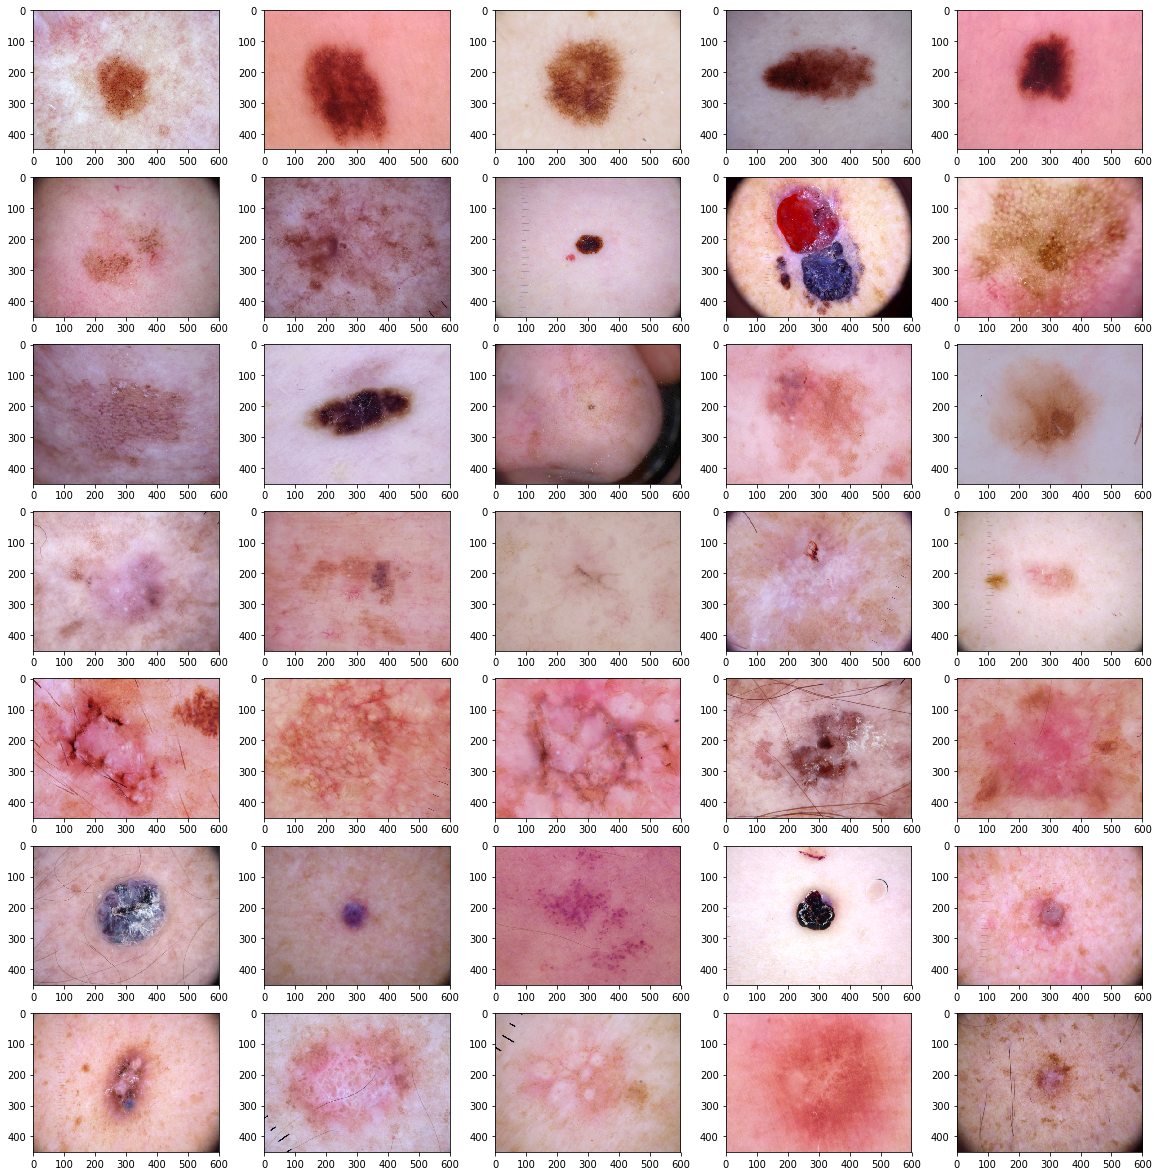

In [19]:
N_SAMPLES = 5

list_dx = df_meta['dx'].value_counts().index.tolist()
file_dx = {}

for dx in list_dx:
    file_dx[dx] = []
    image_ids = df_meta[df_meta['dx']==dx].sample(N_SAMPLES).index.tolist()
    for image_id in image_ids:
        file_dx[dx].append('./Images/{}.jpg'.format(image_id))


print('Showing images for skin cancer types {}:'.format(str(list_dx)))
        
fig, axs = plt.subplots(len(list_dx),N_SAMPLES, figsize = (4 * N_SAMPLES, 3 * len(list_dx)))
for dx in list_dx:
    for image_filename in file_dx[dx]:
        image = misc.imread(image_filename)
        axs[list_dx.index(dx)][file_dx[dx].index(image_filename)].imshow(image)

## IV. Modeling

In [20]:
def cnn(size, n_layers):
    # INPUTS
    # size     - size of the input images
    # n_layers - number of layers
    # OUTPUTS
    # model    - compiled CNN

    # Define hyperparamters
    MIN_NEURONS = 64
    MAX_NEURONS = 256 # change this, make it 256, 512
    KERNEL = (3, 3)

    # Determine the # of neurons in each convolutional layer
    neurons = np.arange(MIN_NEURONS, MAX_NEURONS, MIN_NEURONS/2)
    neurons = neurons.astype(np.int32)

    # Define a model
    model = Sequential()

    # Add convolutional layers
    for i in range(0, n_layers):
        if i == 0:
            shape = (size[0], size[1], size[2])
            model.add(Conv2D(neurons[i], KERNEL, padding='same', input_shape=shape))
        else:
            model.add(Conv2D(neurons[i], KERNEL, padding='same'))
        
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

    # Add max pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.40))
    model.add(Flatten())
    
    model.add(Dense(MAX_NEURONS))
    model.add(Activation('relu'))
    model.add(Dropout(0.50))

    # Add output layer
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Print a summary of the model
    model.summary()

    return model

In [21]:
# Instantiate the model
N_LAYERS = 4
image_size = np.asarray([x_train.shape[1], x_train.shape[2], x_train.shape[3]])
model = cnn(size=image_size, n_layers=N_LAYERS)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 180, 135, 64)      1792      
_________________________________________________________________
activation_1 (Activation)    (None, 180, 135, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 90, 67, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 67, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 67, 96)        55392     
_________________________________________________________________
activation_2 (Activation)    (None, 90, 67, 96)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 45, 33, 96)        0         
__________

In [22]:
# Training hyperparamters
EPOCHS = 64
BATCH_SIZE = 16

# Add a Reduction of Learning Rate to the model in case it tapers off
reduce_lr = ReduceLROnPlateau(monitor='acc', factor=0.5, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

In [23]:
# Train the model
model_history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=[reduce_lr])

Epoch 1/64
8012/8012 [==============================] - 19s 2ms/step - loss: 1.0522 - acc: 0.6674
Epoch 2/64
8012/8012 [==============================] - 17s 2ms/step - loss: 0.9785 - acc: 0.6710
Epoch 3/64
8012/8012 [==============================] - 17s 2ms/step - loss: 0.9397 - acc: 0.6732
Epoch 4/64
8012/8012 [==============================] - 17s 2ms/step - loss: 0.8954 - acc: 0.6814
Epoch 5/64
8012/8012 [==============================] - 17s 2ms/step - loss: 0.8817 - acc: 0.6827
Epoch 6/64
8012/8012 [==============================] - 17s 2ms/step - loss: 0.8547 - acc: 0.6971
Epoch 7/64
8012/8012 [==============================] - 17s 2ms/step - loss: 0.8392 - acc: 0.6923
Epoch 8/64
8012/8012 [==============================] - 17s 2ms/step - loss: 0.8236 - acc: 0.6966
Epoch 9/64
8012/8012 [==============================] - 17s 2ms/step - loss: 0.7986 - acc: 0.7054
Epoch 10/64
8012/8012 [==============================] - 17s 2ms/step - loss: 0.7923 - acc: 0.7051
Epoch 11/64
8012/80

## V. Model Evaluation

In [24]:
# Evaluate the Model
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=1, batch_size=BATCH_SIZE)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1, batch_size=BATCH_SIZE)

print("Train: accuracy = %f  ;  loss = %f" % (train_acc, train_loss))
print("Test: accuracy = %f  ;  loss = %f" % (test_acc, test_loss))

2003/2003 [==============================] - 2s 1ms/step
Train: accuracy = 0.805916  ;  loss = 0.538583
Test: accuracy = 0.720419  ;  loss = 0.809779


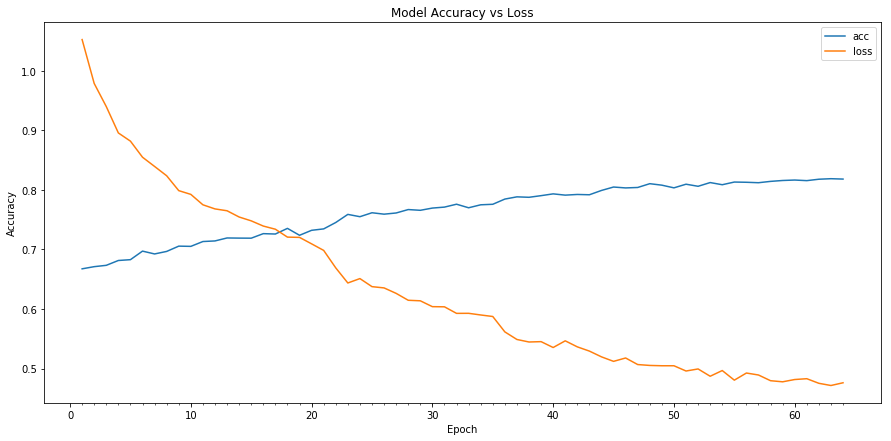

In [25]:
fig, axs = plt.subplots(1,1,figsize=(15,7))

# Plot History for Accuracy vs Loss
axs.plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
axs.plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
axs.set_title('Model Accuracy vs Loss')
axs.set_ylabel('Accuracy')
axs.set_xlabel('Epoch')
axs.set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
axs.legend(['acc', 'loss'], loc='best')

In [26]:
# Make a prediction on the test set
y_pred = model.predict(x_test)
y_pred = np.round(y_pred)

In [27]:
# Compare the Confusion Matrix with the value counts of the test data
confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))

array([[  48,    4,    7,    0,    0,   10,    0],
       [  48,   24,    1,    0,    1,   17,    2],
       [ 110,    7,   23,    0,    2,   86,    0],
       [  12,    1,    1,    3,    0,   11,    0],
       [  91,    1,    4,    0,   13,  115,    2],
       [  77,    5,    5,    1,    0, 1246,    4],
       [   4,    0,    0,    0,    0,    5,   12]])

In [28]:
y_test.sum(axis=0)

dx_akiec      69
dx_bcc        93
dx_bkl       228
dx_df         28
dx_mel       226
dx_nv       1338
dx_vasc       21
dtype: int64

In [29]:
# Check the Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.04      0.08        69
           1       0.57      0.26      0.36        93
           2       0.56      0.10      0.17       228
           3       0.75      0.11      0.19        28
           4       0.81      0.06      0.11       226
           5       0.84      0.93      0.88      1338
           6       0.60      0.57      0.59        21

   micro avg       0.82      0.66      0.73      2003
   macro avg       0.65      0.30      0.34      2003
weighted avg       0.77      0.66      0.65      2003
 samples avg       0.66      0.66      0.66      2003



## VI. Summary
- There is a huge data imbalance which some of the data to be misclassified as nv
- Classes with the exception of 'nv' and 'vasc' have low recall but slightly acceptable precision, will require another model to run these classes by itself for better identification or more sample images can be included either by oversampling manually or manually adding new images
- Overall, the model can identify images but there is still room for improvement

In [30]:
# Save the Model
model.save('model-final.h5')